Inicialmente acabei por escolher um modelo simples demais que se mostrou incapaz de realizar a tarefa, por conta disso acabei perdendo algum tempo.

Apartir daqui as coisas começão a funcionar:

In [7]:
import os
import zipfile

# Caminho do arquivo ZIP e diretório de extração
zip_path = '/content/post-processed.zip'
extract_to = '/content/extracted_data'

# Extrair o arquivo ZIP se ele existir
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Data extracted to {extract_to}')
else:
    print(f'File {zip_path} not found. Please check the path.')


Data extracted to /content/extracted_data


In [2]:
!pip install insightface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 41.7 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1055396 sha256=a23bd3890a860d7239aa6ee520ac27966a141afc67d683e9582a1fe163b79304
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface


In [4]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (160, 160)


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


No face detected in /content/extracted_data/post-processed/Cass_Ballenger/Cass_Ballenger_0003_0000.jpg
No face detected in /content/extracted_data/post-processed/Dennis_Hastert/Dennis_Hastert_0003_0004.jpg
No face detected in /content/extracted_data/post-processed/Dennis_Hastert/Dennis_Hastert_0003_0003.jpg
No face detected in /content/extracted_data/post-processed/Edmund_Hillary/Edmund_Hillary_0002_0000.jpg
No face detected in /content/extracted_data/post-processed/Gary_Sayler/Gary_Sayler_0001_0000.jpg
No face detected in /content/extracted_data/post-processed/Gerald_Riley/Gerald_Riley_0002_0000.jpg
No face detected in /content/extracted_data/post-processed/Julian_Fantino/Julian_Fantino_0001_0000.jpg
No face detected in /content/extracted_data/post-processed/Linda_Dano/Linda_Dano_0001_0002.jpg
No face detected in /content/extracted_data/post-processed/Lokendra_Bahadur_Chand/Lokendra_Bahadur_Chand_0002_0000.jpg
No face detected in /content/extracted_data/post-processed/Marcus_Gronholm/

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


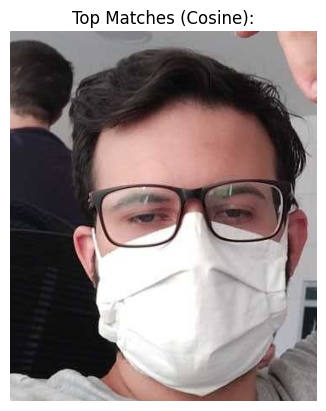

In [8]:
import os
import numpy as np
import torch
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt
from PIL import Image
import insightface
from insightface.app import FaceAnalysis

# Step 1: Initialize the InsightFace Model
def get_arcface_model():
    # Initialize the face analysis app from InsightFace
    app = FaceAnalysis(providers=['CPUExecutionProvider'])  # Use CPU; change if using GPU
    app.prepare(ctx_id=0, det_size=(160, 160))
    return app

# Step 2: Custom Dataset Class
class FaceDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.label_to_idx = {}
        self.idx_to_label = {}

        person_names = sorted([d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))])
        self.label_to_idx = {person_name: idx for idx, person_name in enumerate(person_names)}
        self.idx_to_label = {idx: person_name for idx, person_name in enumerate(person_names)}

        for person_name in person_names:
            person_dir = os.path.join(img_dir, person_name)
            idx = self.label_to_idx[person_name]
            for img_name in os.listdir(person_dir):
                img_path = os.path.join(person_dir, img_name)
                if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

        print(f"Number of classes: {len(self.label_to_idx)}")
        print(f"Max label: {max(self.labels)}")
        print(f"Min label: {min(self.labels)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Step 3: Data Transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Step 4: Function to Extract Descriptors Using ArcFace
def extract_descriptor(app, image_path):
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)  # Convert to numpy array
    faces = app.get(image)

    if len(faces) > 0:
        # Use the embedding of the first detected face
        descriptor = faces[0].embedding
        return descriptor
    else:
        print(f"No face detected in {image_path}")
        return None

# Step 5: Create Database of Descriptors
def create_database(app, img_dir, db_path='/content/celebrity_db.pkl'):
    data = {'Name': [], 'Descriptor': []}
    person_names = sorted([d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))])

    for person_name in person_names:
        person_dir = os.path.join(img_dir, person_name)
        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                descriptor = extract_descriptor(app, img_path)
                if descriptor is not None:
                    label = os.path.splitext(img_name)[0]
                    data['Name'].append(label)
                    data['Descriptor'].append(descriptor.tolist())

    df = pd.DataFrame(data)
    df.to_pickle(db_path)
    print(f'Database saved to {db_path}')



# Main Script
if __name__ == "__main__":
    extract_to = '/content/extracted_data'
    data_dir = os.path.join(extract_to, 'post-processed')
    image_to_add = '/content/marcelinho_no_db.jpg'
    image_to_infer = '/content/marcelinho_na_inferencia.jpg'
    db_path = '/content/celebrity_db.pkl'

    # Load ArcFace Model
    app = get_arcface_model()

    # Create Database
    create_database(app, data_dir, db_path)


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


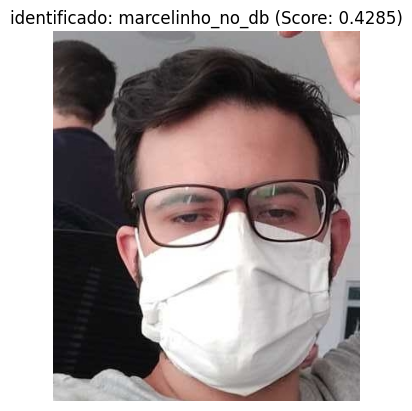

Top 5 Matches (Cosine Similarity):
1. marcelinho_no_db: 0.4285
2. Ben_Affleck_0002_0006: 0.3108
3. Robert_Redford_0001_0001: 0.2984
4. Francois_Ozon_0001_0000: 0.2955
5. Ben_Affleck_0002_0005: 0.2863


In [16]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image
import insightface
from insightface.app import FaceAnalysis

# Step 6: Function to Add Specific Image to Database
def add_to_database(image_path, app, db_path='celebrity_db.pkl'):
    descriptor = extract_descriptor(app, image_path)
    if descriptor is None:
        return

    # Load the existing database
    df = pd.read_pickle(db_path)
    label = os.path.splitext(os.path.basename(image_path))[0]
    new_entry = pd.DataFrame({'Name': [label], 'Descriptor': [descriptor.tolist()]})

    # Concatenate the new entry with the existing database
    df = pd.concat([df, new_entry], ignore_index=True)
    df.to_pickle(db_path)
    print(f'Added {label} to database.')

# Step 7: Perform Inference and Display Metrics
def recognize_face(image_path, app, db_path='celebrity_db.pkl'):
    # Load the database
    df = pd.read_pickle(db_path)
    df['Descriptor'] = df['Descriptor'].apply(lambda x: np.array(x))

    # Extract descriptor for the query image
    query_descriptor = extract_descriptor(app, image_path)
    if query_descriptor is None:
        return

    # Calculate cosine similarity
    descriptors = np.stack(df['Descriptor'].values)
    cosine_scores = cosine_similarity([query_descriptor], descriptors)[0]

    # Get the top match
    top_index = np.argmax(cosine_scores)
    top_name = df.iloc[top_index]['Name']
    top_score = cosine_scores[top_index]

    # Display the query image with the top match name
    plt.imshow(Image.open(image_path))
    plt.title(f"identificado: {top_name} (Score: {top_score:.4f})")
    plt.axis('off')
    plt.show()

    # Print the top 5 matches and scores
    print("Top 5 Matches (Cosine Similarity):")
    top_indices = np.argsort(cosine_scores)[::-1][:5]
    for i, index in enumerate(top_indices):
        name = df.iloc[index]['Name']
        score = cosine_scores[index]
        print(f"{i+1}. {name}: {score:.4f}")

# Main Script
if __name__ == "__main__":
    # Initialize the model
    #app = get_arcface_model()

    # Paths to images and database
    image_to_add = '/content/marcelinho_no_db.jpg'
    image_to_infer = '/content/marcelinho_na_inferencia.jpg'
    db_path = 'celebrity_db.pkl'

    # Add a specific image to the database
    add_to_database(image_to_add, app, db_path)

    # Perform inference and display metrics
    recognize_face(image_to_infer, app, db_path)


In [15]:

import pandas as pd

# Load the DataFrame from the pickle file
df = pd.read_pickle('/content/celebrity_db.pkl')

# Display the DataFrame
df

,Name,Descriptor
0,AJ_Lamas_0001_0000,"[0.06350180506706238, 0.264323890209198, 1.283..."
1,AJ_Lamas_0002_0000,"[-0.1851956844329834, -1.0494011640548706, -0...."
2,Aaron_Eckhart_0002_0002,"[0.5367592573165894, 0.13044627010822296, 0.06..."
3,Aaron_Eckhart_0001_0001,"[-0.7796288132667542, -0.07918622344732285, -0..."
4,Aaron_Eckhart_0001_0002,"[-0.46291959285736084, 0.3456254005432129, -0...."
...,...,...
11979,Zurab_Tsereteli_0004_0000,"[-1.5889701843261719, 0.5865365862846375, -0.6..."
11980,Zydrunas_Ilgauskas_0004_0000,"[-0.9019021987915039, 0.21200640499591827, -1...."
11981,Zydrunas_Ilgauskas_0004_0001,"[0.8356903195381165, 0.39342033863067627, -2.3..."
11982,Zydrunas_Ilgauskas_0001_0000,"[0.06744469702243805, -0.5658867359161377, -0...."


Considerações finais:

Devido as restrições na disponibilidade de uso da gpu no google colab tive de optar por um modelo pre treinado.

Nesse caso optei pelo modelo ArcFace:
Trata-se de uma técnica de reconhecimento facial avançada que usa uma função de perda angular (Angular Margin Loss) para melhorar a discriminação de características faciais em um espaço de embedding. Ele é amplamente utilizado para tarefas de reconhecimento facial em larga escala e é projetado para distinguir com precisão pessoas diferentes, mesmo em condições desafiadoras, como o uso de máscaras faciais.

Podemos notar nos resultados anteriores que defato o modelo conseguiu completar a tarefa acusando a maior similaridade do coseno para a imagem correta no banco de dados, resultando na identificação correta de marcelinho.


A similaridade de cosseno mede o "ângulo" entre dois vetores em um espaço vetorial, em vez de medir a distância linear. A ideia é que, quanto mais próximos os vetores estiverem em termos de direção, mais semelhantes eles são, independentemente do seu comprimento ou magnitude.

Na prática, em problemas de reconhecimento facial, a similaridade de cosseno é frequentemente normalizada para um intervalo de [0, 1], onde:
Próximo de 1: Alta similaridade entre os dois vetores.
Próximo de 0: Baixa similaridade entre os dois vetores.

Ou seja podemos concluir que 0.4285 de similaridade pode ser considerado relativamente baixo,em outras palavras o resultado ainda pode melhorar.

Uma possivel melhoria que poderia ser implementada seria o fine tunnig do modelo mais para isso seria necessario ajustar seus hiperparamentros e aplicar transfer learning para retreinar o modelo antes de extrair os embbedinigs oque demandaria o uso de GPU.
